# FrameView Vision

This notebook uses the default pre-trained on the COCO dataset, and then setting it to evaluation mode. This is then used to gather data on the boundary boxes for the objects recognized in the image tensor. Using the diferences in the pixel coordinates with objects at known distances, the stero camera system is callibrated. After callibration, the stero camera system will begin a loop recognizing objects and sending distance values back to the ESP32s.

#### Project referenced from:
jonathanrandall's ESP32 Stereo Camera
https://github.com/jonathanrandall/esp32_stereo_camera/blob/main/python_notebooks/stereo_image_utils.py

### Contents:
- Import Libraries and Check GPU
- Callibration
    - Pulling Images from ESP32-CAMs
    - Image processing and MCNN
    - Bounding Boxes
    - Finding Distances Using Stereo Cam
    - Determining Focal Length and Theta
- Main Operation
    

### Libraries

In [1]:
import copy
import math

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights,MaskRCNN_ResNet50_FPN_V2_Weights

from pathlib import Path
import cv2
import urllib.request
import numpy as np
import requests
%matplotlib inline


#### Check CUDA environment
This uses a CUDA-enabled environment for pytorch GPU acceleration. If your system does not use CUDA, pytorch will default to CPU usage

In [2]:
#import torch
torch.cuda.is_available()

True

In [3]:
#import torch
torch.cuda.is_available()
torch.cuda.current_device()

0

### Calibration

In [63]:
#import urllib.request

def load_img(image_url):
    req = urllib.request.urlopen(image_url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1) # 'Load it as it is'
    return img

In [64]:
def display_image_pair(first_image, second_image):
    #this funciton from Computer vision course notes 
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here we are creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    # TODO: Call imshow on each of the axes with the first and second images
    #       Make sure you handle both RGB and grayscale images
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)

    plt.show()

In [65]:
def rotate_image_ccw(image):
    # Rotate the image 90 degrees counter clockwise
    return np.rot90(image, k=1, axes=(0, 1))

def rotate_image_cw(image):
    # Rotate the image 90 degrees clockwise
    return np.rot90(image, k=3, axes=(0, 1))

In [66]:
left_eye_url = 'http://192.168.137.48/capture'
right_eye_url = "http://192.168.137.105/capture"

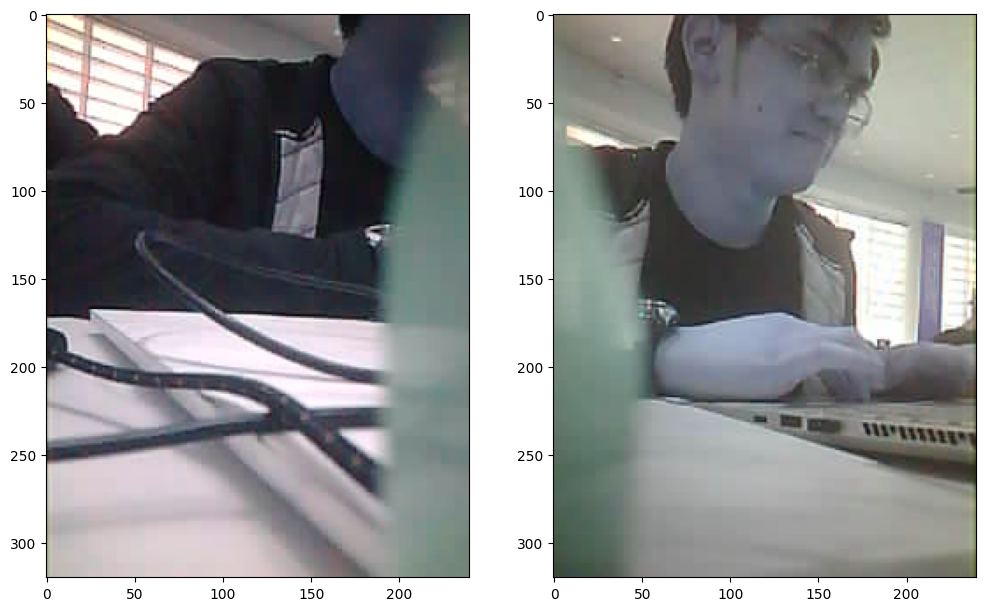

In [67]:
cap_left = load_img(left_eye_url)
cap_left = rotate_image_ccw(cap_left)
cap_right = load_img(right_eye_url)
cap_right = rotate_image_cw(cap_right)
display_image_pair(cap_left, cap_right)
imgs = [cap_left, cap_right]


In [53]:
sz1 = cap_right.shape[1]
sz2 = cap_right.shape[0]

In [54]:
weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)
_ = model.eval()


In [55]:
def preprocess_image(image):
    image = np.array(image)
    image = image.copy()  # make a copy to ensure that there are no negative strides
    image = tvtf.to_tensor(image).cuda()
    image = image.unsqueeze(dim=0)
    return image

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.cuda()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [25]:
def get_detections(maskrcnn, imgs, score_threshold=0.7):
    det = []
    lbls = []
    scores = []
    masks = []
    
    for img in imgs:
        with torch.no_grad():
            result = maskrcnn(preprocess_image(img))[0]
    
        mask = result["scores"] > score_threshold

        boxes = result["boxes"][mask].detach().cpu().numpy()
        det.append(boxes)
        lbls.append(result["labels"][mask].detach().cpu().numpy())
        scores.append(result["scores"][mask].detach().cpu().numpy())
#         masks.append(result["masks"][mask].detach().cpu().numpy())
        masks.append(result["masks"][mask]) #I want this as a tensor
        
    # det is bounding boxes, lbls is class labels, scores are confidences and masks are segmentation masks
    return det, lbls, scores, masks

#det[0] are the bounding boxes in the left image
#det[1] are the bounding boxes in the right image

In [68]:
%%time 
det, lbls, scores, masks = get_detections(model,imgs)

CPU times: total: 4.31 s
Wall time: 1.63 s


In [69]:
print(np.array(weights.meta["categories"])[lbls[0]])
print(np.array(weights.meta["categories"])[lbls[1]])

['person']
['person']


In [70]:
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [71]:
#draws the bounding boxes
def draw_detections(img, det, colours=COLOURS, obj_order = None):
    for i, (tlx, tly, brx, bry) in enumerate(det):
        if obj_order is not None and len(obj_order) < i:
            i = obj_order[i]
        i %= len(colours)
        c = colours[i]
        
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)


#annotate the class labels
def annotate_class(img, det, lbls, conf=None, colours=COLOURS, class_map=weights.meta["categories"]):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[lbls[i]]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the 
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_DUPLEX
        #ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


def draw_instance_segmentation_mask(img, masks):
    ''' Draws segmentation masks over an img '''
    seg_colours = np.zeros_like(img, dtype=np.uint8)
    for i, mask in enumerate(masks):
        col = (mask[0, :, :, None] * COLOURS[i])
        seg_colours = np.maximum(seg_colours, col.astype(np.uint8))
    cv2.addWeighted(img, 0.75, seg_colours, 0.75, 1.0, dst=img)    
    


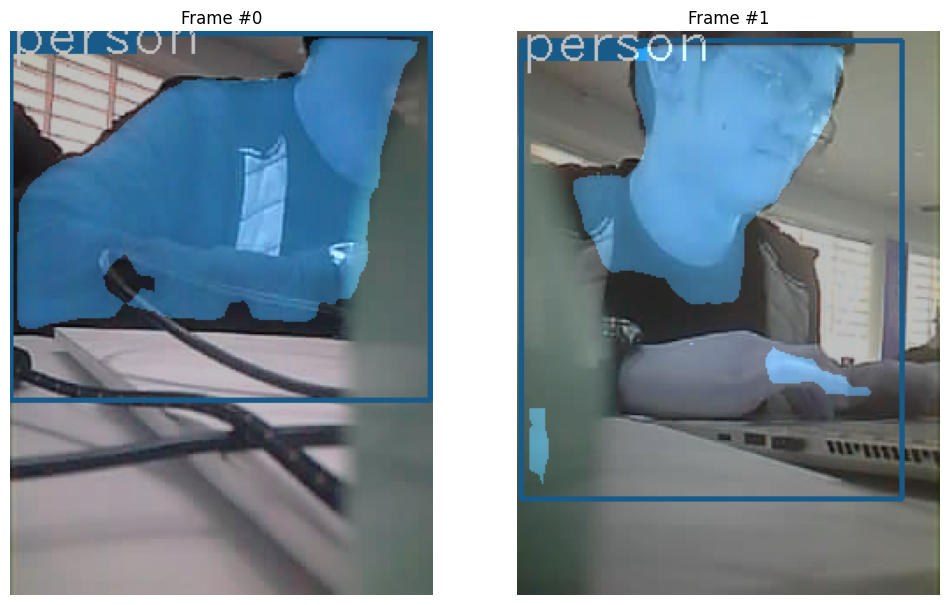

In [72]:
#draw with masks

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
# imgs2 = imgs.copy()

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti)
    masks[i][masks[i]<0.7]=0
    masksi = masks[i].detach().cpu().numpy()
    annotate_class(img,deti,lbls[i])
    draw_instance_segmentation_mask(img, masksi)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')

In [73]:
#get centr, top left and bottom right of boxes

def tlbr_to_center1(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+brx)/2
        cy = (tly+bry)/2
        points.append([cx, cy])
    return points

def tlbr_to_corner(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (tlx+tlx)/2
        cy = (tly+tly)/2
        points.append((cx, cy))
    return points

def tlbr_to_corner_br(boxes):
    points = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx+brx)/2
        cy = (bry+bry)/2
        points.append((cx, cy))
    return points

def tlbr_to_area(boxes):
    areas = []
    for tlx, tly, brx, bry in boxes:
        cx = (brx-tlx)
        cy = (bry-tly)
        areas.append(abs(cx*cy))
    return areas


In [74]:
#get all distances from every object box to every other object box
#left image is boxes[0]
#right image is boxes[1]

#do broad casting.
#in python, col vector - row vector gives matrix:
# [a] - [c,d] = [a-c, a-d]
# [b]           [b-c, b-d]

def get_horiz_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_tl(boxes):
    pnts1 = np.array(tlbr_to_corner(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_horiz_dist_corner_br(boxes):
    pnts1 = np.array(tlbr_to_corner_br(boxes[0]))[:,0]
    pnts2 = np.array(tlbr_to_corner_br(boxes[1]))[:,0]
    return pnts1[:,None] - pnts2[None]

def get_vertic_dist_centre(boxes):
    pnts1 = np.array(tlbr_to_center1(boxes[0]))[:,1]
    pnts2 = np.array(tlbr_to_center1(boxes[1]))[:,1]
    return pnts1[:,None] - pnts2[None]

def get_area_diffs(boxes):
    pnts1 = np.array(tlbr_to_area(boxes[0]))
    pnts2 = np.array(tlbr_to_area(boxes[1]))
    return abs(pnts1[:,None] - pnts2[None])

In [75]:
## get distance between corner and centre

centre = sz1/2

def get_dist_to_centre_tl(box, cntr = centre):
    pnts = np.array(tlbr_to_corner(box))[:,0]
    return abs(pnts - cntr)


def get_dist_to_centre_br(box, cntr = centre):
    pnts = np.array(tlbr_to_corner_br(box))[:,0]
    
    return abs(pnts - cntr)



In [76]:

tmp1 = get_dist_to_centre_br(det[0])
tmp2 = get_dist_to_centre_br(det[1])
print(tmp1)
print(tmp2)

[118.57885742]
[98.24217224]


In [77]:
#create the tracking cost function.
#consists of theree parts.
#  1. The vertical move up and down of object centre of mass. Scale this up because we do not expect this to be very much.
#  2. The move left or right by the object. We only expect it to move right (from the left eye image). So penalise if it moves left.
#  3. The difference in area of pixels. Area of image is width x height, so divide by height, there for this will have max value of width

def get_cost(boxes, lbls = None, sz1 = 400):
    alpha = sz1; beta  = 10; gamma = 5
    
    #vertical_dist, scale by gamma since can't move up or down
    horiz_dist = gamma*abs(get_horiz_dist_centre(boxes))
    
    #horizonatl distance.
    vert_dist = get_vertic_dist_centre(boxes)
    
    #increase cost if object has moved from right to left.
    vert_dist[vert_dist<0] = beta*abs(vert_dist[vert_dist<0])
    
    #area of box
    area_diffs = get_area_diffs(boxes)/alpha
    
    cost = np.array([horiz_dist,vert_dist,area_diffs])
    
    cost=cost.sum(axis=0)
    
    #add penalty term for different object classes
    if lbls is not None:
        for i in range(cost.shape[0]):
            for j in range(cost.shape[1]):
                if (lbls[0][i]!=lbls[1][j]):
                    cost[i,j]+=150
    return cost
   


In [78]:
def get_tracks(cost):
    return scipy.optimize.linear_sum_assignment(cost)
    

def get_tracks_ij(cost):
    tracks = scipy.optimize.linear_sum_assignment(cost)
    return [[i,j] for i, j in zip(*tracks)]


In [79]:
cost = get_cost(det, lbls = lbls)

In [80]:
tracks = scipy.optimize.linear_sum_assignment(cost)
print(tracks)

h_d = [[np.array(weights.meta["categories"])[lbls[0]][i],np.array(weights.meta["categories"])[lbls[1]][j]] for i, j in zip(*tracks)]
print(np.array(weights.meta["categories"])[lbls[0]])
print(h_d)

(array([0], dtype=int64), array([0], dtype=int64))
['person']
[['person', 'person']]


In [81]:
#we take the corner that is closest to the centre. This is because the other corner might be going off the image.

dists_tl =  get_horiz_dist_corner_tl(det)
dists_br =  get_horiz_dist_corner_br(det)

final_dists = []
dctl = get_dist_to_centre_tl(det[0])
dcbr = get_dist_to_centre_br(det[0])

for i, j in zip(*tracks):
    if dctl[i] < dcbr[i]:
        final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        
    else:
        final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        

final_dists

[(20.336685180664062, 'person')]

In [82]:
#bottle at 50 cm = 223.48483276367188
bottle_50 = 223.48483276367188
#bottle at 30 cm = 373.6793632507324
bottle_30 = 373.6793632507324
focal_length = 30-bottle_50*50/bottle_30
focal_length

0.0967119485111354

In [83]:
#calibrate theta. cameras are 7.05 cms apart
cam_dist = 14.8
tantheta = (1/(50-focal_length))*(cam_dist/2)*sz1/bottle_50
print(tantheta)

0.15924497817565844


In [43]:
esp_data = []
for i in range(len(dists_away)):
    cat_tuple = (np.array(weights.meta["categories"])[lbls[0]][i], dists_away[i])
    esp_data.append(cat_tuple)
    print(f'{np.array(weights.meta["categories"])[lbls[0]][i]} is {dists_away[i]:.1f}cm away')

print(esp_data)

NameError: name 'dists_away' is not defined

In [87]:
#final distances as list
fd = [i for (i,j) in final_dists]
print(fd)

[20.336685180664062]


In [88]:
dists_away = (cam_dist/2)*sz1*(1/tantheta)/np.array(fd)+focal_length

In [89]:
cat_dist = []
for i in range(len(dists_away)):
    cat_dist.append(f'{np.array(weights.meta["categories"])[lbls[0]][i]} {dists_away[i]:.1f}cm')
    print(f'{np.array(weights.meta["categories"])[lbls[0]][i]} is {dists_away[i]:.1f}cm away')

person is 548.5cm away


In [90]:
#annotate the class labels
def annotate_class2(img, det, lbls,class_map, conf=None,  colours=COLOURS):
    for i, ( tlx, tly, brx, bry) in enumerate(det):
        txt = class_map[i]
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the 
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1
        
        cv2.rectangle(img, 
                      (tlx-offset, tly-offset+12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i%len(colours)],
                      thickness=cv2.FILLED)
        
        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1+12), fontFace=ff, fontScale=1.0, color=(255,)*3)


In [91]:
list(np.array(cat_dist)[(tracks[0])])

['person 548.5cm']

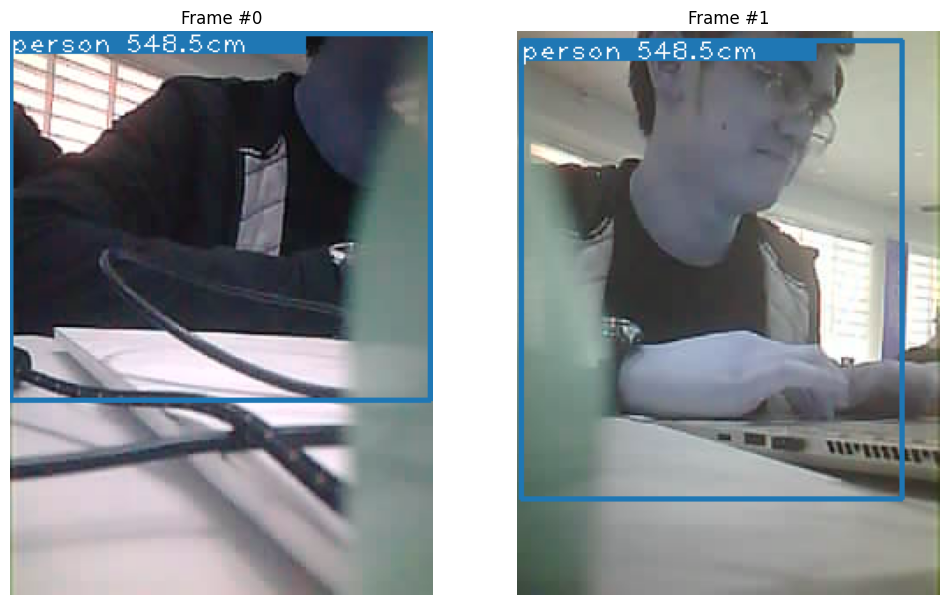

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

t1 = [list(tracks[1]), list(tracks[0])]

for i, imgi in enumerate(imgs):
    img = imgi.copy()
    deti = det[i].astype(np.int32)
    draw_detections(img,deti[list(tracks[i])], obj_order=list(t1[i]))
    annotate_class2(img,deti[list(tracks[i])],lbls[i][list(tracks[i])],cat_dist)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Frame #{i}')
    

In [93]:
import requests
import json

In [94]:
def send_array_to_esp32_1(esp_data):
    url = "http://192.168.137.215"
    headers = {"Content-Type": "application/json"}
    response = requests.post(url, data=json.dumps(esp_data), headers=headers)
    if response.status_code == 200:
        print("Data sent and processed")
    else:
        print("Error:", response.text)
        
def send_array_to_esp32_2(esp_data):
    url = "http://192.168.137.119"
    headers = {"Content-Type": "application/json"}
    response = requests.post(url, data=json.dumps(esp_data), headers=headers)
    if response.status_code == 200:
        print("Data sent and processed")
    else:
        print("Error:", response.text)    

# Loop Running

In [95]:
import time

while True:
    
    #user_input = input("Enter 'stop' to exit the loop: ")
    
    cap_left = load_img(left_eye_url)
    cap_left = rotate_image_cw(cap_left)
    cap_right = load_img(right_eye_url)
    cap_right = rotate_image_ccw(cap_right)
    #display_image_pair(cap_left, cap_right)
    imgs = [cap_left, cap_right]
    #plt.imshow(img)
    sz1 = cap_right.shape[1]
    sz2 = cap_right.shape[0]
    det, lbls, scores, masks = get_detections(model,imgs)
    caml_obj = det[0].size
    camr_obj = det[1].size
    print("running")
    #print(det[1].size)
    #print(det[0].size == 0)
    #print(det[1].size == 0)
    
    
    if (caml_obj != 0) and (camr_obj != 0):
        print("Detected")
        centre = sz1/2
        tmp1 = get_dist_to_centre_br(det[0])
        tmp2 = get_dist_to_centre_br(det[1])
        
        cost = get_cost(det, lbls = lbls)
        horizontal_dist = get_horiz_dist_centre(det)
        print(horizontal_dist)
        
        tracks = scipy.optimize.linear_sum_assignment(cost)
        h_d = [[np.array(weights.meta["categories"])[lbls[0]][i],np.array(weights.meta["categories"])[lbls[1]][j]] for i, j in zip(*tracks)]
        dists_tl =  get_horiz_dist_corner_tl(det)
        dists_br =  get_horiz_dist_corner_br(det)

        final_dists = []
        dctl = get_dist_to_centre_tl(det[0])
        dcbr = get_dist_to_centre_br(det[0])

        
        for i, j in zip(*tracks):
            if dctl[i] < dcbr[i]:
                final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
            else:
                final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        
        fd = [i for (i,j) in final_dists]

        for i, j in zip(*tracks):
            if dctl[i] < dcbr[i]:
                final_dists.append((dists_tl[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
        
            else:
                final_dists.append((dists_br[i][j],np.array(weights.meta["categories"])[lbls[0]][i]))
    
    
        dists_away = (cam_dist/2)*sz1*(1/tantheta)/np.array(fd)+focal_length
        esp_data = []
        
        for i in range(len(dists_away)):
            cat_tuple = (np.array(weights.meta["categories"])[lbls[0]][i], dists_away[i])
            esp_data.append(cat_tuple)
            print("works")
            
        print(esp_data)
        # Convert tuples to lists
        esp_data_lists = [list(item) for item in esp_data]

        esp_data_example = [['sink', 540.6689197582725], ['person', 114.31624150756721]]
        # Send the esp_data to the ESP32
        #send_array_to_esp32(esp_data_lists)
        send_array_to_esp32_1(esp_data_example)
        send_array_to_esp32_2(esp_data_example)

        
    #time.sleep(0.2)


running
Detected
[[2.30892181]]
works
[('bus', -210.5021193462858)]


ConnectTimeout: HTTPConnectionPool(host='192.168.137.215', port=80): Max retries exceeded with url: / (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x0000024E838C1960>, 'Connection to 192.168.137.215 timed out. (connect timeout=None)'))